# Knn 
We have ~500K recipes and we would like to cluster these recipes. We have pre-processed the data and scaled all the numeric values. also we used some llm pretrained models to generate embedding from the text data for each recipe. Now before doing any neural network, we would like to perfom some analysis to understand how the data looks like and can we find similar recipes and can we do clustering in the space of the input features. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [3]:
MODEL_NAME = "all-mpnet-base-v2" # The pretrained model that was used to embed the text

In [4]:


# Load the file, explicitly setting allow_pickle=True
data = np.load(f"input_data/{MODEL_NAME}_vae_input_data.npz", allow_pickle=True)

# These commands will now work:
text_embeds = data["text_embeds"]
numeric_scaled = data["numeric_scaled"]
recipes_df_loaded = data["recipes"] 

# If 'recipes' was saved as a NumPy object array containing a single DataFrame object,
# you will need to extract the DataFrame from the resulting 0-dim array:
recipes_df = pd.DataFrame(data["recipes"], index=None).drop(columns=['Unnamed: 0'])

# If it was saved as a simple object array (less likely for a full df), the .item() might not be needed.
# If the .item() call fails, just use recipes_df = recipes_df_loaded

print("Data loaded successfully!")
# print(type(recipes_df)) # Should show <class 'pandas.core.frame.DataFrame'>

Data loaded successfully!


In [5]:
print(text_embeds.shape)
print(numeric_scaled.shape)
print(recipes_df.shape)

(506933, 768)
(506933, 11)
(506933, 19)


In [6]:
recipes_df.head()

,RecipeId,Name,AuthorId,AuthorName,DatePublished,RecipeCategory,RecipeIngredientParts,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeInstructions,PrepTime_minutes,TotalTime_minutes
0,39,Biryani,1567,elly9812,1999-08-29T13:12:00Z,Chicken Breast,"c(""saffron"", ""milk"", ""hot green chili peppers""...",1110.7,58.8,16.6,372.8,368.4,84.4,9.0,20.4,63.4,"c(""Soak saffron in warm milk for 5 minutes and...",240.0,265.0
1,40,Best Lemonade,1566,Stephen Little,1999-09-05T19:52:00Z,Beverages,"c(""sugar"", ""lemons, rind of"", ""lemon, zest of""...",311.1,0.2,0.0,0.0,1.8,81.5,0.4,77.2,0.3,"c(""Into a 1 quart Jar with tight fitting lid, ...",30.0,35.0
2,42,Cabbage Soup,1538,Duckie067,1999-09-19T06:19:00Z,Vegetable,"c(""plain tomato juice"", ""cabbage"", ""onion"", ""c...",103.6,0.4,0.1,0.0,959.3,25.1,4.8,17.7,4.3,"c(""Mix everything together and bring to a boil...",20.0,50.0
3,43,Best Blackbottom Pie,34879,Barefoot Beachcomber,1999-08-21T10:35:00Z,Pie,"c(""graham cracker crumbs"", ""sugar"", ""butter"", ...",437.9,19.3,10.9,94.3,267.6,58.0,1.8,42.5,7.0,"c(""Graham Cracker Crust: In small bowl, combin...",20.0,140.0
4,44,Warm Chicken A La King,1596,Joan Edington,1999-09-17T04:47:00Z,Chicken,"c(""chicken"", ""butter"", ""flour"", ""milk"", ""celer...",895.5,66.8,31.9,405.8,557.2,29.1,3.1,5.0,45.3,"c(""Melt 1 1/2 ozs butter, add the flour and co...",35.0,38.0


In [7]:
X = np.hstack([text_embeds, numeric_scaled])
print("Combined shape:", X.shape)
n_dim = X.shape[1]

Combined shape: (506933, 779)


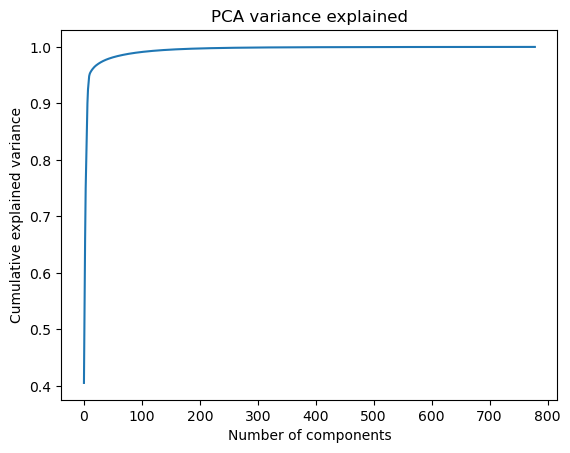

In [8]:
pca = PCA(n_components=n_dim)
X_pca = pca.fit_transform(X)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA variance explained")
plt.show()

In [9]:
np.cumsum(pca.explained_variance_ratio_)[50]

np.float64(0.9815830110067493)

Since 50 components can explain more than 98 percents of the data, we keep 50 and discard the rest

In [10]:
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)

In [38]:
import matplotlib.pyplot as plt
from umap import UMAP

umap_2d = UMAP(n_neighbors=30, min_dist=0.1, n_components=2, random_state=42)
X_umap = umap_2d.fit_transform(X_pca)

/home/fahimeh/miniconda3/envs/recipe/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/fahimeh/miniconda3/envs/recipe/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


# ELBOW method

To estimate the number of clusters to use in the KMean, we can plot the inertia (sum of squared distances to nearest cluster center) for different k. Look for the “elbow” — where adding more clusters stops reducing inertia significantly.

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

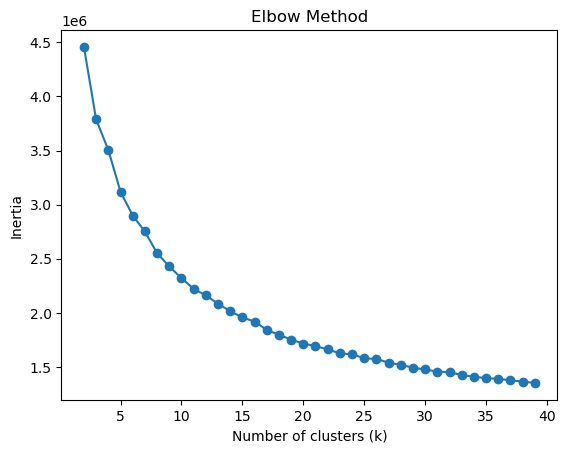

In [21]:
inertias = []
K = range(2, 40)

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    km.fit(X_pca)
    inertias.append(km.inertia_)

plt.plot(K, inertias, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

As you can see there is not an clear elbow, which shows that in our data, most probably there is not a clear boundry between the clusters

# Silhouette Score

This measures, how well each point fits within its cluster vs other clusters

In [35]:
sample_size = 10000
sample_idx = np.random.choice(X_pca.shape[0], sample_size, replace=False)
X_pca_sample = X_pca[sample_idx]

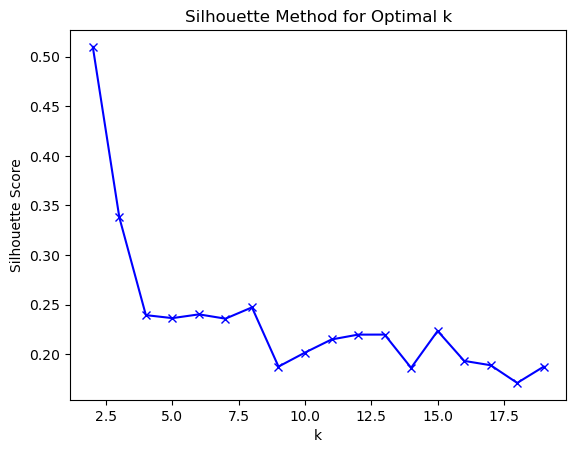

In [36]:
scores = []
K = range(2, 20)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_pca_sample)
    score = silhouette_score(X_pca_sample, kmeans.labels_)
    scores.append(score)

plt.plot(K, scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal k')
plt.show()

Here’s how to interpret that pattern:

	•	k = 2 gives the highest silhouette score → The data can be roughly divided into two large, distinct groups.

	•	Sharp drop from k = 2 to k = 3 → After splitting into more clusters, the new clusters become less well-separated (more overlap).

	•	Plateau after ~k = 17 → Beyond that, adding clusters doesn’t really improve structure; it’s just breaking large groups into smaller, less meaningful ones.

What to do next

You can explore both levels:

	1.	Macro view: Run KMeans with k=2 or even k=3 and color your UMAP by these to see the big separation pattern.

	2.	Micro view: Run KMeans (or HDBSCAN) with around k=10–20 to explore finer groups and interpret what’s inside each.

We perfom Kmeans on the PCA data becasue PCA keeps global structure (it preserves variance in the data). It gives a compact, denoised representation (e.g., 50 components instead of 779 features). It’s much faster and more stable for algorithms like KMeans, which work better in lower-dimensional, continuous spaces. But then we use the UMAP for visualization.

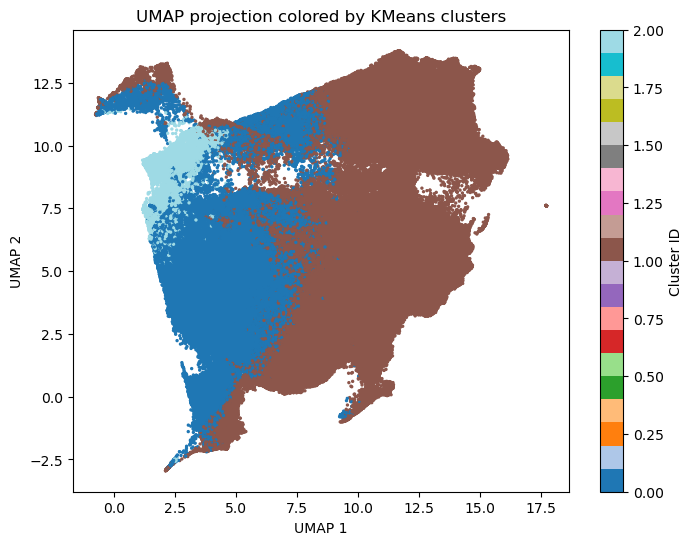

In [46]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
labels = kmeans.fit_predict(X_pca)

# --- Plot ---
plt.figure(figsize=(8,6))
plt.scatter(X_umap[:,0], X_umap[:,1], c=labels, cmap='tab20', s=2)
plt.colorbar(label='Cluster ID')
plt.title('UMAP projection colored by KMeans clusters')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

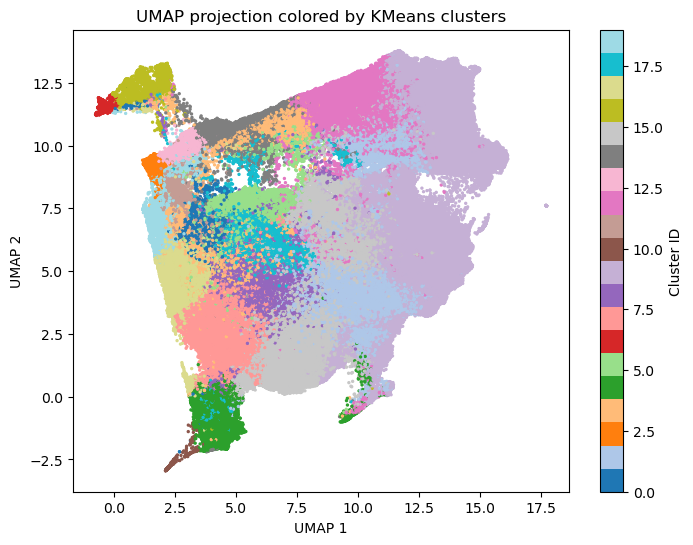

In [41]:
kmeans = KMeans(n_clusters=20, random_state=42, n_init='auto')
labels = kmeans.fit_predict(X_pca)

# --- Plot ---
plt.figure(figsize=(8,6))
plt.scatter(X_umap[:,0], X_umap[:,1], c=labels, cmap='tab20', s=2)
plt.colorbar(label='Cluster ID')
plt.title('UMAP projection colored by KMeans clusters')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

In [47]:
recipes_df['cluster'] = labels
recipes_df.head()

,RecipeId,Name,AuthorId,AuthorName,DatePublished,RecipeCategory,RecipeIngredientParts,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeInstructions,PrepTime_minutes,TotalTime_minutes,cluster
0,39,Biryani,1567,elly9812,1999-08-29T13:12:00Z,Chicken Breast,"c(""saffron"", ""milk"", ""hot green chili peppers""...",1110.7,58.8,16.6,372.8,368.4,84.4,9.0,20.4,63.4,"c(""Soak saffron in warm milk for 5 minutes and...",240.0,265.0,0
1,40,Best Lemonade,1566,Stephen Little,1999-09-05T19:52:00Z,Beverages,"c(""sugar"", ""lemons, rind of"", ""lemon, zest of""...",311.1,0.2,0.0,0.0,1.8,81.5,0.4,77.2,0.3,"c(""Into a 1 quart Jar with tight fitting lid, ...",30.0,35.0,1
2,42,Cabbage Soup,1538,Duckie067,1999-09-19T06:19:00Z,Vegetable,"c(""plain tomato juice"", ""cabbage"", ""onion"", ""c...",103.6,0.4,0.1,0.0,959.3,25.1,4.8,17.7,4.3,"c(""Mix everything together and bring to a boil...",20.0,50.0,1
3,43,Best Blackbottom Pie,34879,Barefoot Beachcomber,1999-08-21T10:35:00Z,Pie,"c(""graham cracker crumbs"", ""sugar"", ""butter"", ...",437.9,19.3,10.9,94.3,267.6,58.0,1.8,42.5,7.0,"c(""Graham Cracker Crust: In small bowl, combin...",20.0,140.0,1
4,44,Warm Chicken A La King,1596,Joan Edington,1999-09-17T04:47:00Z,Chicken,"c(""chicken"", ""butter"", ""flour"", ""milk"", ""celer...",895.5,66.8,31.9,405.8,557.2,29.1,3.1,5.0,45.3,"c(""Melt 1 1/2 ozs butter, add the flour and co...",35.0,38.0,0


In [48]:
recipes_df['cluster'].value_counts().reset_index()

,cluster,count
0,1,361384
1,0,133558
2,2,11991


In [50]:
recipes_df[recipes_df['cluster']==0]['RecipeCategory'].value_counts().reset_index()

,RecipeCategory,count
0,One Dish Meal,15872
1,Lunch/Snacks,9509
2,Dessert,8441
3,Meat,6809
4,Chicken,6733
...,...,...
285,Broccoli Soup,1
286,Roast Beef Crock Pot,1
287,Spaghetti Sauce,1
288,Key Lime Pie,1


In [51]:
recipes_df[recipes_df['cluster']==1]['RecipeCategory'].value_counts().reset_index()

,RecipeCategory,count
0,Dessert,48236
1,Vegetable,23344
2,Lunch/Snacks,22091
3,Beverages,15087
4,One Dish Meal,14889
...,...,...
288,Deep Fried,1
289,Oysters,1
290,Turkey Gravy,1
291,Coconut Cream Pie,1


In [54]:
recipes_df[(recipes_df['cluster']==0) & (recipes_df['RecipeCategory']=="One Dish Meal")]

,RecipeId,Name,AuthorId,AuthorName,DatePublished,RecipeCategory,RecipeIngredientParts,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeInstructions,PrepTime_minutes,TotalTime_minutes,cluster
1526,3116,Chicken Biryani,148316,- Carla -,1999-10-05T00:16:00Z,One Dish Meal,"c(""basmati rice"", ""salt"", ""whole cardamom pods...",763.3,32.6,7.5,114.2,437.1,72.2,6.8,9.8,45.9,"c(""Preheat the oven to 375°F."", ""Bring a pan o...",15.0,90.0,0
2311,4110,Lasagna Pierogi,1534,Tonkcats,1999-11-10T01:13:00Z,One Dish Meal,"c(""potatoes"", ""onions"", ""butter"", ""margarine"",...",620.9,39.9,25.0,109.8,529.1,55.4,6.3,4.1,13.5,"c(""Cook lasagna and drain."", ""Chop onions and ...",0.0,0.0,0
4609,7949,Tortellini Ai Formaggi With Prosciutto and Peas,148316,- Carla -,2000-03-13T21:44:00Z,One Dish Meal,"c(""water"", ""butter"", ""garlic cloves"", ""prosciu...",1137.3,71.7,43.0,276.0,1389.8,92.7,6.1,5.0,33.5,"c(""Cook tortellini according to package direct...",5.0,15.0,0
4727,8079,Mexican Fiesta Casserole,148316,- Carla -,2000-03-13T21:47:00Z,One Dish Meal,"c(""lean ground beef"", ""chili powder"", ""cheddar...",511.1,31.1,13.6,89.7,848.3,33.0,2.7,8.0,24.8,"c(""Preheat the oven to 375F."", ""Cook the groun...",15.0,50.0,0
5096,8500,Chicken Stir-Fry,3014,DALE DRAGER,2000-11-03T10:55:00Z,One Dish Meal,"c(""boneless skinless chicken breast"", ""soy sau...",665.6,26.3,4.9,102.2,1089.3,65.1,7.0,7.6,45.4,"c(""Cook cut cup chicken breast strips in salad...",10.0,25.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505858,540223,Kadai Chicken Recipe,2002702579,kartik v.,2020-05-01T21:22:00Z,One Dish Meal,"c(""chicken breasts"", ""onion"", ""onion"", ""green ...",563.5,33.9,15.8,164.5,2572.6,31.1,7.5,12.7,37.5,"c(""How to make Kadai Chicken Recipe:"", ""Heat a...",30.0,60.0,0
506349,540764,Sevtap's Turkish Chicken,78626,Baz231,2020-07-31T22:43:00Z,One Dish Meal,"c(""chicken thigh"", ""olive oil"", ""onion"", ""grou...",903.6,62.8,12.9,210.0,210.2,39.3,7.1,27.6,51.0,"c(""Heat the olive oil in a large pan and fry t...",5.0,55.0,0
506415,540833,Tuna Chili Pearl Couscous &ldquo;Risotto&rdquo;,78626,Baz231,2020-08-17T15:51:00Z,One Dish Meal,"c(""couscous"", ""chunk tuna"", ""leek"", ""butter"", ...",686.4,14.0,7.0,65.8,1008.4,85.0,6.4,6.6,51.5,"c(""Melt butter in a large saucepan over medium...",5.0,30.0,0
506680,541116,Delicious Dutch Oven Pot Roast,2002830233,Chef Ken Stoneback,2020-10-26T15:00:00Z,One Dish Meal,"c(""carrots"", ""celery"", ""onion"", ""bulb of garli...",636.8,27.9,10.3,224.5,662.6,12.7,2.2,4.1,74.3,"c(""Preheat oven to 275. Salt the Chuck Roast. ...",20.0,260.0,0


In [55]:
recipes_df[(recipes_df['cluster']==1) & (recipes_df['RecipeCategory']=="One Dish Meal")]

,RecipeId,Name,AuthorId,AuthorName,DatePublished,RecipeCategory,RecipeIngredientParts,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeInstructions,PrepTime_minutes,TotalTime_minutes,cluster
695,1119,Spaghetti Pie,1530,Carole Reu,1999-08-18T04:58:00Z,One Dish Meal,"c(""spaghetti"", ""egg"", ""nonfat parmesan cheese""...",192.8,4.3,1.7,60.6,390.0,20.6,1.7,3.0,17.4,"c(""Cook spaghetti for 10 to 12 minutes or unti...",5.0,25.0,1
2125,3858,Shepherd's Pie With Eggplant (Aubergine),1549,Dave5003,1999-11-02T05:06:00Z,One Dish Meal,"c(""potatoes"", ""butter"", ""yogurt"", ""chives"", ""p...",262.8,9.6,5.6,25.3,511.6,36.6,8.5,7.0,10.9,"c(""Preheat oven to 350°F."", ""Cook the potatoes...",30.0,70.0,1
2153,3893,Vegetarian Shepherd's Pie,1886,HELEN PEAGRAM,1999-11-10T01:13:00Z,One Dish Meal,"c(""parsley"", ""adzuki beans"", ""brown rice"", ""wa...",309.8,4.3,0.7,0.0,364.9,59.0,9.2,5.9,10.9,"c(""Wash the beans and rice in plenty of cold w...",0.0,0.0,1
2885,4902,Corn Side Dish,1642,M Messer,1999-11-24T07:18:00Z,One Dish Meal,"c(""celery"", ""green pepper"", ""olive oil"", ""froz...",147.5,3.1,0.5,0.0,725.6,30.2,4.1,11.3,4.0,"c(""In 2-1/2 to 3 qt casserole dish, toss celer...",10.0,25.0,1
2909,4934,Crock Pot Cabbage Rolls,1885,Linda Sorichetti,1999-11-26T04:45:00Z,One Dish Meal,"c(""cabbage"", ""lean ground beef"", ""ground lamb""...",227.4,7.9,3.2,49.1,478.8,21.1,2.6,5.0,18.0,"c(""Wash cabbage leaves."", ""Boil 4 cups water.""...",0.0,480.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505577,539841,Super-Easy Fondue Bourguignonne,2001004241,CLUBFOODY,2020-02-11T18:57:00Z,One Dish Meal,"c(""olive oil"", ""garlic cloves"", ""low sodium be...",173.1,4.7,1.4,39.5,712.0,10.8,1.2,2.7,15.9,"c(""In a medium saucepan over medium heat, add ...",5.0,17.0,1
505808,540132,Stewed Beef with Vegetables,2002700856,IgorKabo,2020-04-21T14:26:00Z,One Dish Meal,"c(""beef"", ""potato"", ""onion"", ""carrot"", ""bay le...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"c(""Beef entrecote, weighing 1 kg, I will wash ...",15.0,315.0,1
506427,540845,Tomato Feta Shrimp,993446,Pawsfurthought,2020-08-20T19:22:00Z,One Dish Meal,"c(""olive oil"", ""onion"", ""garlic cloves"", ""drie...",238.2,11.0,4.9,168.3,1115.7,14.0,3.2,7.8,21.8,"c(""In a large nonstick skillet, heat oil over ...",10.0,25.0,1
506571,540998,Sea Breeze Mushroom Pasta,2002817949,ongwienkai1980,2020-09-24T16:51:00Z,One Dish Meal,"c(""angel hair pasta"", ""button mushrooms"", ""cel...",588.3,30.5,18.5,96.8,115.3,65.7,3.4,3.1,13.4,"c(""Cut button mushrooms into thin slices."", ""M...",30.0,40.0,1
